# Лабораторная работа №0 — Перемножение матриц

В данной лабораторной работе был реализован алгоритм перемножения матриц на CPU и GPU с применением CUDA.

**Входные данные:** 2 матрицы размером от 100х100 до 2000х2000 каждая.

**Выходные данные:** проверка корректности перемножения + время вычисления.

In [1]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [2]:
!nvidia-smi

Wed Jan  5 22:48:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Реализация

На вход программы подаются три матрицы NxN. Каждая матрица разбивается на блоки 32х32, каждая нить вычисляет один элемент блока результирующей матрицы С.

In [3]:
import numpy as np
from numba import cuda, float32
from time import time

In [4]:
BLOCK_SIZE = 32

In [5]:
@cuda.jit
def matmul(A, B, C):
    sA = cuda.shared.array(shape=(BLOCK_SIZE, BLOCK_SIZE), dtype=float32)
    sB = cuda.shared.array(shape=(BLOCK_SIZE, BLOCK_SIZE), dtype=float32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x   

    x, y = cuda.grid(2)
    if x >= C.shape[0] and y >= C.shape[1]:
        return

    # скалярное произведение разбивается на скалярные произведения векторов длиной BLOCK_SIZE.
    tmp = 0.
    for i in range(bpg):
        sA[tx, ty] = A[x, ty + i * BLOCK_SIZE]
        sB[tx, ty] = B[tx + i * BLOCK_SIZE, y]

        cuda.syncthreads()

        for j in range(BLOCK_SIZE):
            tmp += sA[tx, j] * sB[j, ty]
        cuda.syncthreads()

    C[x, y] = tmp

## Проверка корректности перемножения

In [8]:
y = [2 ** i for i in range(7, 12)]
presision = 1e-3
x_cpu = []
x_gpu = []
acc = []
for i in range(len(y)):
    MATRIX_SIZE = y[i]
    
    A = np.random.randn(MATRIX_SIZE, MATRIX_SIZE).astype(np.float32)
    B = np.random.randn(MATRIX_SIZE, MATRIX_SIZE).astype(np.float32)
    C = np.zeros((MATRIX_SIZE, MATRIX_SIZE)).astype(np.float32)

    ctic = time()
    c_cpu = np.dot(A, B)
    ctoc = float(time() - ctic)

    A_gpu = cuda.to_device(A)
    B_gpu = cuda.to_device(B)
    C_gpu = cuda.to_device(C)
    
    gtic = time()
    matmul[(MATRIX_SIZE // BLOCK_SIZE, MATRIX_SIZE // BLOCK_SIZE), 
                (BLOCK_SIZE, BLOCK_SIZE, 1)](A_gpu, B_gpu, C_gpu)
    gtoc = float(time() - gtic)
    
    x_cpu.append(ctoc)
    x_gpu.append(gtoc)
    acc.append(ctoc / gtoc)

    print("N:", y[i], "Корректность результата:", np.all(np.abs(C_gpu.copy_to_host() - c_cpu) < presision))

N: 128 Корректность результата: True
N: 256 Корректность результата: True
N: 512 Корректность результата: True
N: 1024 Корректность результата: True
N: 2048 Корректность результата: True


## Эксперименты

На рисунках ниже представлены графики для времени работы алгоритмов и ускорения.

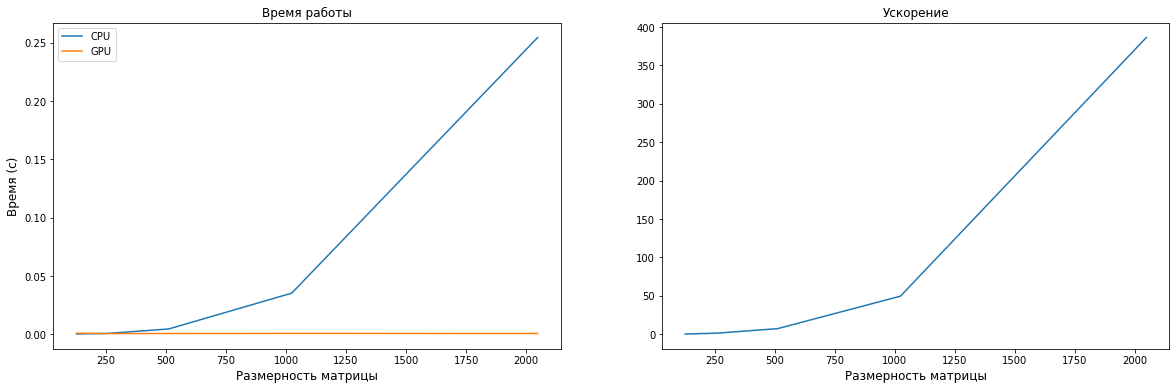

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(y, x_cpu, label='CPU')
plt.plot(y, x_gpu, label='GPU')
plt.legend()
plt.title(label='Время работы')
plt.ylabel('Время (с)', fontsize=12)
plt.xlabel('Размерность матрицы', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(y, acc)
plt.title(label='Ускорение')
plt.xlabel('Размерность матрицы', fontsize=12)

plt.show()

Таким образом, ускорение с увеличением размерностей матриц возрастает. 